# **Dependências do Projeto**

In [1]:
%pip install torch torchvision torchaudio
#Instalando o pytorch

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [3]:
#Caso não consiga pydirectinput
%pip install pyautogui

Note: you may need to restart the kernel to use updated packages.


In [4]:
#Biblioteca de aprendizado por reforço
%pip install stable-baselines3[extra] protobuf==3.20.*

Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install mss pydirectinput pytesseract

Note: you may need to restart the kernel to use updated packages.


In [6]:
%pip install

Note: you may need to restart the kernel to use updated packages.


ERROR: You must give at least one requirement to install (see "pip help install")


# **Imports**

In [192]:
#Para captura de tela
from mss import mss
#import pyautogui #para comandos de teclado
import cv2 
#Tratamentos dos frames
import numpy as np 
import pyautogui
#Framework intermediário paara trabalhar com as imagens
#import pytesseract #para extrair o game over da imagem
from matplotlib import pyplot as plt #Visualizando resultados
import time
from PIL import Image
#Coisas para construir o ambinete
from gym import Env
from gym.spaces import Box, Discrete

# **Construindo o Ambiente**

### Teste de Funções do Ambiente

In [262]:
#Classe para definir o ambiente
class WebGame(Env):
    #ESSAS FUNÇÃO SÃO NECESSÁRIAS POR CONTA DO GYM
    #Função responsavel pela inicialização do ambiente;
    #Portanto onde ficam todas as variaveis do ambiente, configuração das ações e da observação 
    def __init__(self):
        super().__init__()

        self.action_dict = {
            0:'down',
            1:'up',
            2:'nothing'
        }

        #Configuração do espaço
        self.width = 500
        self.height = 250
        self.reduce_scale = 5
        self.reduced_width = int(self.width/self.reduce_scale)
        self.reduced_height = int(self.height/self.reduce_scale)
        
        self.observation_space = Box(low=0, high=255, shape=(1,self.reduced_height,self.reduced_width), dtype=np.uint8)
        self.action_space = Discrete(3)
        self.image_count = 2
        self.action_interval = 0.1
        self.episode_duration = 3.0
        self.episode_timer = 0.0

        #Variavei para a captura de tela
        self.screen_cap = mss() #Lib de captura de tela
        self.game_location = {"left": 200, "top": 150, "width": self.width, "height": self.height} #Área do monitor com 
        self.game_done = {"top": 40, "left": 0, "width": 800, "height": 640}

        self.first_image = np.zeros(5)
        self.last_image = np.zeros((500,650,3))


    #Função responsavel por passar as ações pro jogo, para fazer algo pro jogo
    def step(self, action):
        # Se ação escolhida for um dos botões, realizar a ação.
        self.take_action(action)
        
        #Checa a próxima ação
        observation, game_over = self.get_observation()

        # Gerenciar timer
        done = False
        self.episode_timer += self.action_interval
        if self.episode_timer >= self.episode_duration or game_over:
            self.episode_timer = 0.0
            done = True

        #Ganhamos 1 ponto se vivos, -50 se mortos (PANACA).
        reward = 1 if not game_over else -50
        info = {}
        
        if game_over:
            env.reset()

        return observation, reward, done, info
        

    #Função para a visualização do jogo:
    def render(self):
        cv2.imshow('Game', np.array(self.cap.grab(self.game_location))[:,:,:3])
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()


    #Função responsavel por recomeçar o jogo
    def reset(self):
        time.sleep(1)
        pyautogui.press('up')
        obs, _ = self.get_observation()
        return obs
    

    #FUNÇÕES CUSTOM
    #Fecha a parte de visualização
    def close(self):
        cv2.destroyAllWindows()
    

    #Função responsavel por pegar a imagem do jogo e tratar da forma necessária.
    def get_observation(self):
        images = []

        for i in range(self.image_count):
            raw, channel = self.get_screen(i)

            # yes this sucks I know
            if i == self.image_count-2:
                self.first_image = raw
            elif i == self.image_count-1:
                self.last_image = raw

            # each loop
            time.sleep(self.action_interval/self.image_count)
            images.append(channel)

        #Pegando nesse ponto para evitar a imagem cortada.
        done = np.all(np.equal(self.first_image, self.last_image))

        return images[0], done
    

    def get_screen(self, i):
        # Grab the data
        raw = np.array(self.screen_cap.grab(self.game_location))[:,:,:3].astype(np.uint8)

        # yes this sucks I know
        if i == self.image_count-2:
            self.first_image = raw
        elif i == self.image_count-1:
            self.last_image = raw

        # image preprocessing
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (self.reduced_width, self.reduced_height))
        channel = np.reshape(resized, (1, self.reduced_height, self.reduced_width))

        # Debug: Save to png
        #img.save(output, "PNG")
        #processed_img.save("processed_" + output, "PNG")

        return raw, channel


    def take_action(self, action):
        if action != 2:
            pyautogui.press(self.action_dict[action])


    #Função para pegar o texto de fim de jogo:
    def get_done(self):
        #Se as duas imagens iniciais forem iguais acabou jogo
        done = False
        #Colando a primeira condição devido ao fator de que as formas diferentes estavam dando problema na comparação devido ao np.all
        if self.first_image.shape[0] != self.last_image.shape[0]:
            return done, self.last_image

        if np.all(np.equal(self.first_image, self.last_image)):
            done = True
        
        return done, self.last_image

In [263]:
env = WebGame()

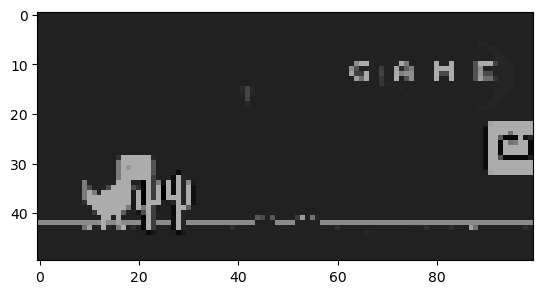

In [264]:
#Teste para a captura de Imagem
time.sleep(2)
testes, _ = env.get_observation()
teste = testes
#Mostrando a imagem capturada
plt.imshow(cv2.cvtColor(teste[0], cv2.COLOR_GRAY2BGR))

In [265]:
#Teste para ver se o jogo acaba
done, done_cap = env.get_done()

True


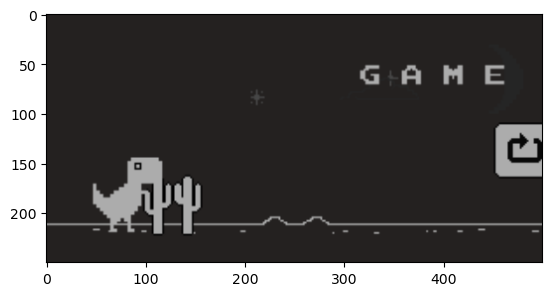

In [266]:
#Mostrando uma imagem de fim de jogo
print(done)
plt.imshow(env.last_image)

In [267]:
#10 partidas
for episode in range(10): 
    done = False  
    total_reward = 0
    while not done: 
        obs, reward,  done, info =  env.step(env.action_space.sample()) #
        total_reward  += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))   

Total Reward for episode 0 is -50
Total Reward for episode 1 is -50
Total Reward for episode 2 is -28
Total Reward for episode 3 is -27
Total Reward for episode 4 is -29
Total Reward for episode 5 is -29
Total Reward for episode 6 is -50
Total Reward for episode 7 is -25
Total Reward for episode 8 is -27
Total Reward for episode 9 is -28


# Treinamento

In [268]:
# Import os for file path management
import os 
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback
# Verificando se o ambiente é válido para fazer as coisa
from stable_baselines3.common import env_checker

In [269]:
# Verificando se o ambiente é válido para fazer as coisa
env_checker.check_env(env)

In [270]:
#Salvando o modelo em uma pasta chamado de treino
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [271]:
#Criandos as pastas para que funcione.
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [272]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

In [273]:
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack

In [274]:
env = WebGame()

In [275]:
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size=12000, learning_starts=1000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [279]:
#Começa o treinamento
model.learn(total_timesteps=10000, callback=callback)

Logging to ./logs/DQN_7
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.8     |
|    ep_rew_mean      | -28.2    |
|    exploration_rate | 0.914    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 3        |
|    time_elapsed     | 29       |
|    total_timesteps  | 91       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.9     |
|    ep_rew_mean      | -30.1    |
|    exploration_rate | 0.841    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 2        |
|    time_elapsed     | 55       |
|    total_timesteps  | 167      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.2     |
|    ep_rew_mean      | -30.8    |
|    exploration_rate | 0.77     |
| time/               |        

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.1     |
|    ep_rew_mean      | -27.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 80       |
|    fps              | 3        |
|    time_elapsed     | 519      |
|    total_timesteps  | 1606     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.73     |
|    n_updates        | 151      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.1     |
|    ep_rew_mean      | -27.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 84       |
|    fps              | 3        |
|    time_elapsed     | 548      |
|    total_timesteps  | 1690     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.73     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.8     |
|    ep_rew_mean      | -26.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 144      |
|    fps              | 3        |
|    time_elapsed     | 901      |
|    total_timesteps  | 2870     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.55     |
|    n_updates        | 467      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.8     |
|    ep_rew_mean      | -26.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 148      |
|    fps              | 3        |
|    time_elapsed     | 927      |
|    total_timesteps  | 2944     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 6.2      |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.1     |
|    ep_rew_mean      | -29.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 208      |
|    fps              | 3        |
|    time_elapsed     | 1293     |
|    total_timesteps  | 4109     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0185   |
|    n_updates        | 777      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.3     |
|    ep_rew_mean      | -29.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 212      |
|    fps              | 3        |
|    time_elapsed     | 1321     |
|    total_timesteps  | 4200     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.74     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19       |
|    ep_rew_mean      | -27.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 272      |
|    fps              | 3        |
|    time_elapsed     | 1691     |
|    total_timesteps  | 5339     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.87     |
|    n_updates        | 1084     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.3     |
|    ep_rew_mean      | -27.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 276      |
|    fps              | 3        |
|    time_elapsed     | 1718     |
|    total_timesteps  | 5425     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.83     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.4     |
|    ep_rew_mean      | -27.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 336      |
|    fps              | 3        |
|    time_elapsed     | 2106     |
|    total_timesteps  | 6615     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.14     |
|    n_updates        | 1403     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.4     |
|    ep_rew_mean      | -27.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 340      |
|    fps              | 3        |
|    time_elapsed     | 2129     |
|    total_timesteps  | 6686     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.32     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.2     |
|    ep_rew_mean      | -26.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 400      |
|    fps              | 3        |
|    time_elapsed     | 2504     |
|    total_timesteps  | 7838     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.32     |
|    n_updates        | 1709     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.1     |
|    ep_rew_mean      | -26.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 404      |
|    fps              | 3        |
|    time_elapsed     | 2530     |
|    total_timesteps  | 7917     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.09     |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.2     |
|    ep_rew_mean      | -27.2    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 464      |
|    fps              | 3        |
|    time_elapsed     | 2909     |
|    total_timesteps  | 9062     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.241    |
|    n_updates        | 2015     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 18.9     |
|    ep_rew_mean      | -28      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 468      |
|    fps              | 3        |
|    time_elapsed     | 2931     |
|    total_timesteps  | 9124     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.84     |
|    n_updates      

In [277]:
model.load('train_first/best_mode_5800') 

FileNotFoundError: [Errno 2] No such file or directory: 'train_first\\best_mode_5800.zip'

# Teste

In [280]:
for episode in range(5): 
    obs = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(int(action))
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))

Total Reward for episode 0 is -50
Total Reward for episode 1 is -36
Total Reward for episode 2 is -37
Total Reward for episode 3 is -32
Total Reward for episode 4 is -36
